In [8]:
import numpy as np
import time
import math

def tricubic(x):
    y = np.zeros_like(x)
    idx = (x >= -1) & (x <= 1)
    y[idx] = np.power(1.0 - np.power(np.abs(x[idx]), 3), 3)
    return y

class Loess(object):
    @staticmethod
    def normalize_array(array):
        min_val = np.min(array)
        max_val = np.max(array)
        return (array - min_val) / (max_val - min_val), min_val, max_val

    def __init__(self, xx, yy, degree=1):
        self.n_xx, self.min_xx, self.max_xx = self.normalize_array(xx)
        self.n_yy, self.min_yy, self.max_yy = self.normalize_array(yy)
        self.degree = degree

    @staticmethod
    def get_min_range(distances, window):
        min_idx = np.argmin(distances)
        n = len(distances)
        if min_idx == 0:
            return np.arange(0, window)
        if min_idx == n-1:
            return np.arange(n - window, n)

        min_range = [min_idx]
        while len(min_range) < window:
            i0 = min_range[0]
            i1 = min_range[-1]
            if i0 == 0:
                min_range.append(i1 + 1)
            elif i1 == n-1:
                min_range.insert(0, i0 - 1)
            elif distances[i0-1] < distances[i1+1]:
                min_range.insert(0, i0 - 1)
            else:
                min_range.append(i1 + 1)
        return np.array(min_range)

    @staticmethod
    def get_weights(distances, min_range):
        max_distance = np.max(distances[min_range])
        weights = tricubic(distances[min_range] / max_distance)
        return weights

    def normalize_x(self, value):
        return (value - self.min_xx) / (self.max_xx - self.min_xx)

    def denormalize_y(self, value):
        return value * (self.max_yy - self.min_yy) + self.min_yy

    def estimate(self, x, window, use_matrix=False, degree=1):
        n_x = self.normalize_x(x)
        distances = np.abs(self.n_xx - n_x)
        min_range = self.get_min_range(distances, window)
        weights = self.get_weights(distances, min_range)

        wm = np.multiply(np.eye(window), weights)
        xm = np.ones((window, degree + 1))

        xp = np.array([[math.pow(n_x, p)] for p in range(degree + 1)])

        for i in range(1, degree + 1):
            xm[:, i] = np.power(self.n_xx[min_range], i)

        ym = self.n_yy[min_range]
        xmt_wm = np.transpose(xm) @ wm
        beta = np.linalg.pinv(xmt_wm @ xm) @ xmt_wm @ ym
        y = (beta @ xp)[0]
        return self.denormalize_y(y)

In [9]:
xx = np.array([0.5578196, 2.0217271, 2.5773252, 3.4140288, 4.3014084,
               4.7448394, 5.1073781, 6.5411662, 6.7216176, 7.2600583,
               8.1335874, 9.1224379, 11.9296663, 12.3797674, 13.2728619,
               14.2767453, 15.3731026, 15.6476637, 18.5605355, 18.5866354,
               18.7572812])
yy = np.array([18.63654, 103.49646, 150.35391, 190.51031, 208.70115,
               213.71135, 228.49353, 233.55387, 234.55054, 223.89225,
               227.68339, 223.91982, 168.01999, 164.95750, 152.61107,
               160.78742, 168.55567, 152.42658, 221.70702, 222.69040,
               243.18828])

loess = Loess(xx, yy)

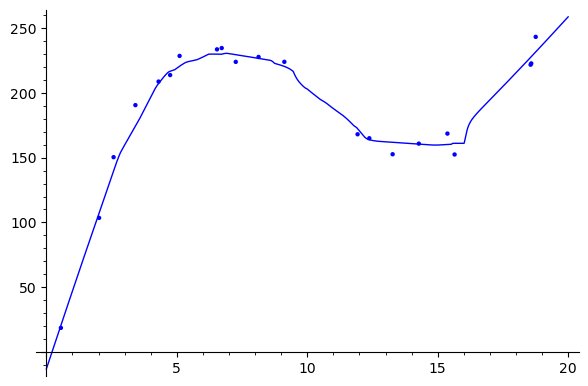

In [14]:
p = plot(lambda x: loess.estimate(x, window=7, degree=1), (x, 0, 20)) + \
    list_plot(np.vstack([xx,yy]).T)
p

In [15]:
x_noise = np.sort(np.random.sample(200) * 4.0 * math.pi)
y_signal =  2 * np.sin(x_noise)
y_noise = y_signal + np.random.normal(0,0.5,x_noise.shape[0])

In [26]:
loess2 = Loess(x_noise, y_noise)

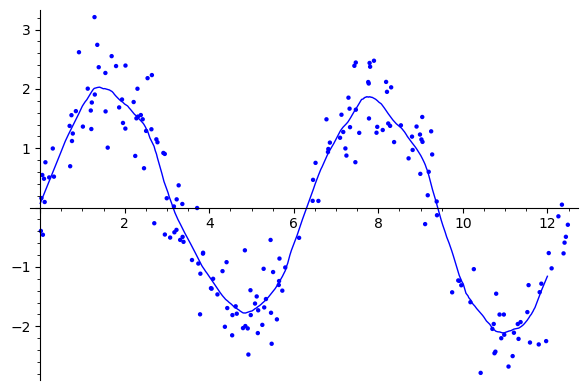

In [28]:
p2 = list_plot(np.vstack([x_noise, y_noise]).T) + \
     plot(lambda x: loess2.estimate(x, window=22, degree=1), (x, 0, 12))
p2